# Results

This section presents exploratory data analysis, and ways to answer RQ1-3 before going into Model Training (Later notebooks)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from datetime import datetime, timedelta
import pytz
from pathlib import Path
from ipywidgets import interact, Dropdown
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon, shapiro, probplot, pearsonr, f_oneway
import cv2
from google.colab.patches import cv2_imshow
from sklearn.impute import SimpleImputer
import random

warnings.filterwarnings('ignore')

Global variables

In [2]:
CECS_698_PATH = '/content/drive/MyDrive/CECS 698 - Data Analysis/'

EMBRACEPLUS_TRIMMED_PATH = os.path.join(CECS_698_PATH, 'EmbracePlus Trimmed')
EMBRACEPLUS_COMBINED_PATH = os.path.join(CECS_698_PATH, 'EmbracePlus Combined')

GAZEPOINT_TRIMMED_PATH = os.path.join(CECS_698_PATH, 'Gazepoint Trimmed')
GAZEPOINT_TUMBLING_WINDOW_DGM = os.path.join(CECS_698_PATH, 'Gazepoint Tumbling Window DGM')
GAZEPOINT_DGM_TIMESTAMP_LABELED = os.path.join(CECS_698_PATH, 'Gazepoint DGM Timestamp Labeled')

PARTICIPANTS = [i for i in range(4, 27)]

MERGED_DATA = os.path.join(CECS_698_PATH, 'Merged Data')

GOOGLE_FORMS_SHEETS = os.path.join(CECS_698_PATH, 'Google Forms Sheets')

GROUP = {
    'E-H': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 24],
    'H-E': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26]
}

# Particpants ids to exclude on specific assessments
EASY_ASSESSMENT_EXCLUDE = [11, 22]
HARD_ASSESSMENT_EXCLUDE = [15, 21]

In [3]:
# Printing directory structure of my data
def print_directory_tree(directory, prefix=""):
    """Recursively print the directory tree."""
    path = Path(directory)
    contents = list(path.iterdir())
    for index, item in enumerate(contents):
        if item.is_dir():
            print(f"{prefix}├── {item.name}/")
            print_directory_tree(item, prefix + "│   ")
        else:
            print(f"{prefix}├── {item.name}")
        if index == len(contents) - 1:
            prefix = prefix[:-4] + "    "

directory_path = MERGED_DATA
print_directory_tree(directory_path)

├── Participant 4/
│   ├── participant4_easy_assessment.csv
│   ├── participant4_hard_assessment.csv
├── Participant 5/
│   ├── participant5_easy_assessment.csv
│   ├── participant5_hard_assessment.csv
├── Participant 6/
│   ├── participant6_hard_assessment.csv
│   ├── participant6_easy_assessment.csv
├── Participant 7/
│   ├── participant7_hard_assessment.csv
│   ├── participant7_easy_assessment.csv
├── Participant 8/
│   ├── participant8_hard_assessment.csv
│   ├── participant8_easy_assessment.csv
├── Participant 9/
│   ├── participant9_easy_assessment.csv
│   ├── participant9_hard_assessment.csv
├── Participant 10/
│   ├── participant10_easy_assessment.csv
│   ├── participant10_hard_assessment.csv
├── Participant 11/
│   ├── participant11_easy_assessment.csv
│   ├── participant11_hard_assessment.csv
├── Participant 12/
│   ├── participant12_easy_assessment.csv
│   ├── participant12_hard_assessment.csv
├── Participant 13/
│   ├── participant13_easy_assessment.csv
│   ├── participant1

# Participant Backgrounds - Pre-Study Questionnaire

In [4]:
pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Pre-Study Questionnaire.csv')).columns

Index(['Timestamp', 'Enter your full name', 'Enter your CSULB email',
       'Enter your student ID', 'Enter your major',
       'Select the current year of study',
       'How many years of experience do you have programming in Python?',
       'Participant ID', 'Status', 'Group #', 'Notes', 'Column 1'],
      dtype='object')

In [5]:
df_pre_study_questionnaire = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Pre-Study Questionnaire.csv'))
df_pre_study_questionnaire = df_pre_study_questionnaire[['How many years of experience do you have programming in Python?', 'Select the current year of study', 'Participant ID', 'Column 1']]
df_pre_study_questionnaire = df_pre_study_questionnaire[df_pre_study_questionnaire['Column 1'].isnull()] # Take out dry run participants
df_pre_study_questionnaire.drop('Column 1', axis=1, inplace=True)

df_pre_study_questionnaire.rename(columns={
    'How many years of experience do you have programming in Python?': 'Python Experience',
    'Select the current year of study': 'Year of Study',
}, inplace=True)

In [6]:
df_pre_study_questionnaire.head()

,Python Experience,Year of Study,Participant ID
4,1 - 2 years,2nd Year Undergraduate,4
5,2 year or more,1st Year Graduate,5
6,1 - 2 years,3rd Year Undergraduate,6
7,1 - 2 years,3rd Year Undergraduate,7
8,1 - 2 years,3rd Year Undergraduate,8


Instances of data loss on Gazepoint (Results from these will be excluded completely):
 - Participant 11, Easy Assessment
 - Participant 22, Easy Assessment
 - Participant 15, Hard Assessment
 - Participant 21, Hard Assessment


# Analysis of Assessment Results

In [7]:
def preprocess_results(df, exclude, assessment_diff):
    df['Participant ID '] = df['Participant ID '].apply(lambda x: int(x))
    df['Score'] = df['Score'].apply(lambda x: int(x.split('/')[0]))
    df = df[~df['Participant ID '].isin(exclude)].reset_index(drop=True) # Exclude participants with data loss
    df['Assessment'] = assessment_diff
    df['Group'] = df['Participant ID '].apply(lambda x: 'E-H' if x in GROUP['E-H'] else 'H-E')

    # Calculcating time to complete each assessment
    for p in df['Participant ID ']:
        merged_data = pd.read_csv(os.path.join(MERGED_DATA, f'Participant {p}', f'participant{p}_{assessment_diff}_assessment.csv'))
        start_time, end_time = merged_data.iloc[0]['timestamp_unix'], merged_data.iloc[-1]['timestamp_unix']

        elapsed_time = end_time - start_time # Elapsed time in milliseconds
        df.loc[df['Participant ID '] == p, 'Elapsed Minutes'] = elapsed_time / 60000  # Convert to minutes (1 min = 60000 ms)

    # Determining pass or fail (LABELS)
    median_score = df['Score'].median()
    df['Successful/Unsuccessful'] = df['Score'].apply(lambda x: 'Successful' if x >= median_score else 'Unsuccessful')

    # Merging data from pre-study questionnaire
    # NOTE:
    #   Participants Sheet - Easy Assessment.csv and Participants Sheet - Easy Assessment.csv have participant ID column as 'Participant ID '
    #   Participants Sheet - Pre-Study Questionnaire.csv has paticipant ID column as 'Participant ID' (WITHOUT SPACE ON THE FRONT)
    df = df.merge(df_pre_study_questionnaire, left_on='Participant ID ', right_on='Participant ID')
    df.drop(columns=['Participant ID'], inplace=True)

    return df

In [8]:
# Exclude dry runs by using bracket notation ([3:] and [4:])
easy_assessment_df = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Easy Assessment.csv'))[['Score', 'Participant ID ']].iloc[3:]
easy_assessment_df = preprocess_results(easy_assessment_df, exclude=EASY_ASSESSMENT_EXCLUDE, assessment_diff='easy')

hard_assessment_df = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Hard Assessment.csv'))[['Score', 'Participant ID ']].iloc[4:]
hard_assessment_df = preprocess_results(hard_assessment_df, exclude=HARD_ASSESSMENT_EXCLUDE, assessment_diff='hard')

In [9]:
easy_assessment_df.describe()[['Score', 'Elapsed Minutes']]

,Score,Elapsed Minutes
count,21.000000,21.000000
mean,21.428571,7.807825
std,4.353980,2.191189
min,10.000000,4.599983
25%,20.000000,6.549850
50%,22.000000,7.866567
75%,25.000000,8.666633
max,27.000000,13.916883


In [10]:
hard_assessment_df.describe()[['Score', 'Elapsed Minutes']]

,Score,Elapsed Minutes
count,21.000000,21.000000
mean,19.571429,21.995894
std,4.422346,7.011284
min,9.000000,6.633267
25%,18.000000,19.283267
50%,21.000000,21.133300
75%,23.000000,26.266650
max,25.000000,35.183250


Assessment 1 seems slightly right skewed. Assessment 2 seems slightly left skewed

In [13]:
df_all_results = pd.concat([easy_assessment_df, hard_assessment_df], axis=0).reset_index(drop=True)

In [14]:
df_all_results.head()

,Score,Participant ID,Assessment,Group,Elapsed Minutes,Successful/Unsuccessful,Python Experience,Year of Study
0,23,4,easy,E-H,10.933250,Successful,1 - 2 years,2nd Year Undergraduate
1,24,5,easy,E-H,7.933283,Successful,2 year or more,1st Year Graduate
2,26,6,easy,E-H,6.566667,Successful,1 - 2 years,3rd Year Undergraduate
3,25,7,easy,E-H,6.249933,Successful,1 - 2 years,3rd Year Undergraduate
4,20,8,easy,E-H,7.866567,Unsuccessful,1 - 2 years,3rd Year Undergraduate


In [15]:
# df_all_results.to_csv(os.path.join(CECS_698_PATH, 'Participant Scores.csv'), index=False)

# Distribution of Labels

Labels we created in the `preprocess_results()` function seem to be well distributed

In [15]:
# Function to add value labels on top of each bar
def add_value_labels(ax):
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()  # Get the height of the bar
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position of the label
                height,  # Y position of the label
                f'{height:.2f}',  # Text to display (formatted to 1 decimal place)
                ha='center',  # Horizontal alignment
                va='bottom'  # Vertical alignment
            )

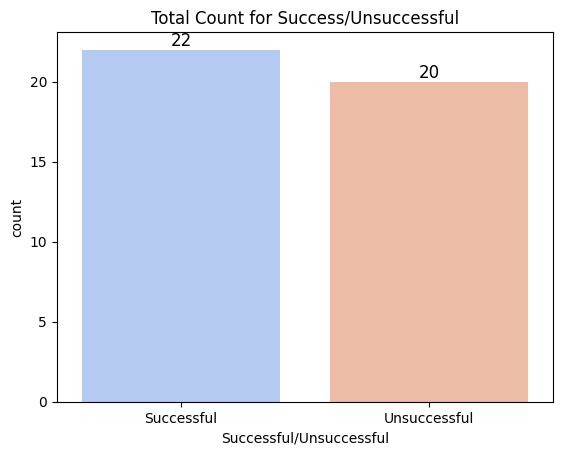

In [21]:
ax = sns.countplot(data=df_all_results, x='Successful/Unsuccessful', palette='coolwarm')

# Add labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Convert count to an integer
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position label at the top
                ha='center', va='bottom',  # Center alignment
                fontsize=12)

# Show the plot
plt.title('Total Count for Success/Unsuccessful')
plt.show()

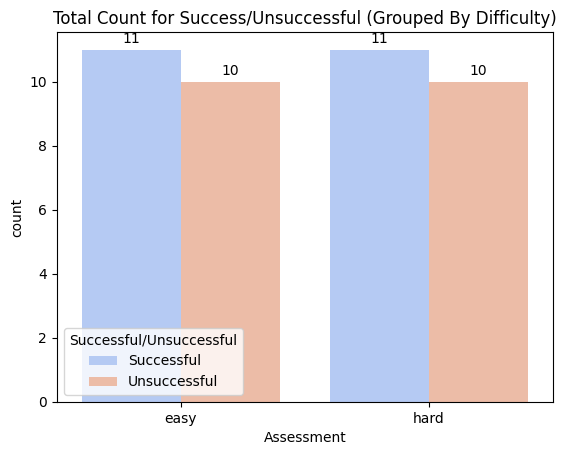

In [22]:
# Create count plot
ax = sns.countplot(data=df_all_results, x="Assessment", hue="Successful/Unsuccessful", palette="coolwarm")

# Add counts above bars
for p in ax.containers:
    ax.bar_label(p, fmt='%d', label_type='edge', padding=3, fontsize=10)

# Add title and show plot
plt.title('Total Count for Success/Unsuccessful (Grouped By Difficulty)')
plt.show()

## Histograms and Hypothesis testing Comparing Assessment Difficulty as x-axis

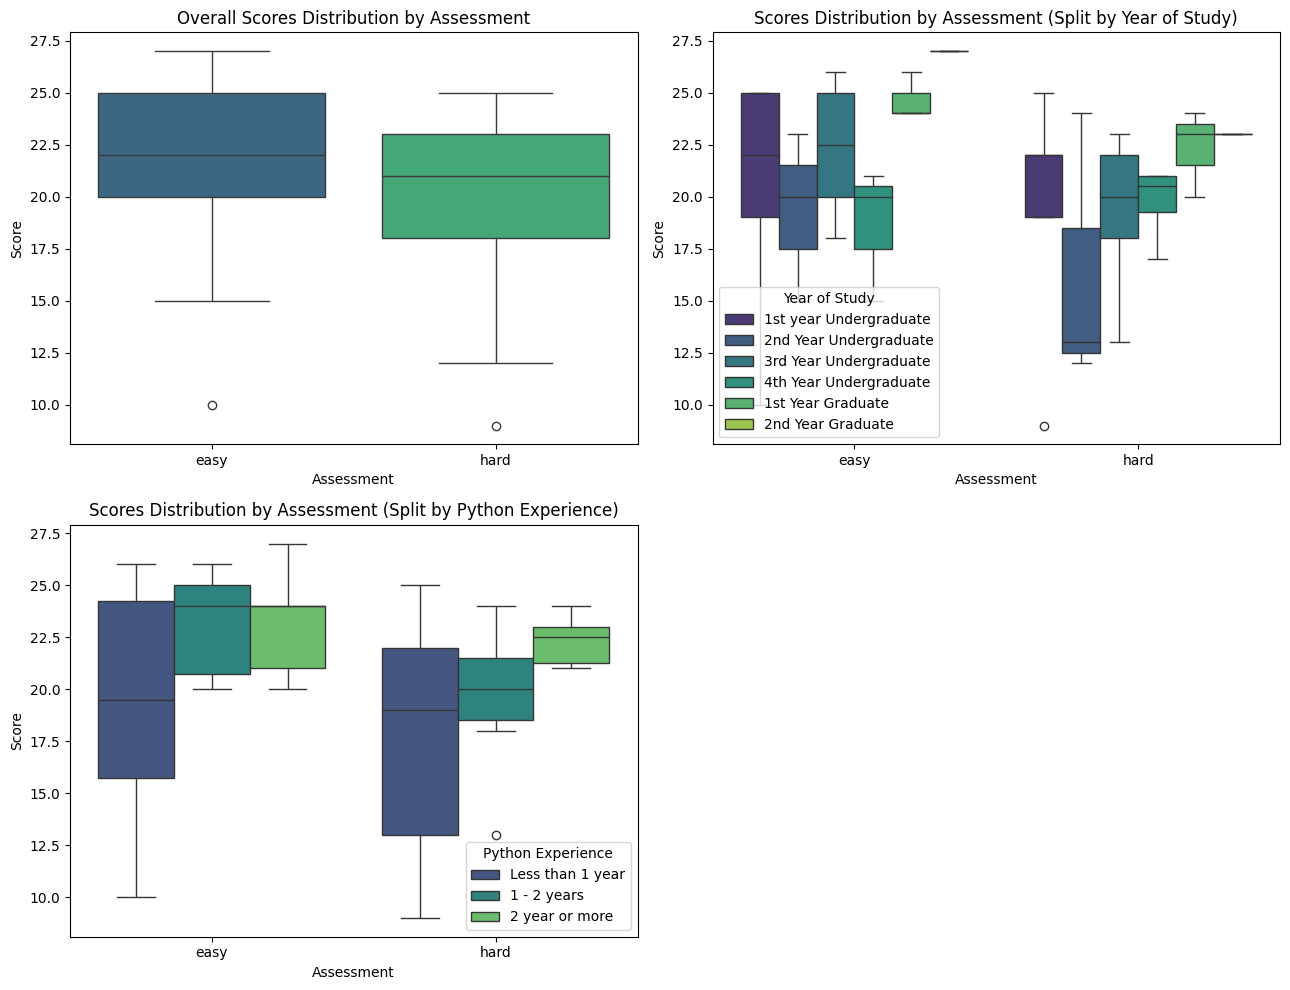

In [23]:
# Define the desired order for 'Year of Study'
year_order = [
    '1st year Undergraduate',
    '2nd Year Undergraduate',
    '3rd Year Undergraduate',
    '4th Year Undergraduate',
    '1st Year Graduate',
    '2nd Year Graduate'
]

experience_order = [
    'Less than 1 year',
    '1 - 2 years',
    '2 year or more'
]

# Convert 'Year of Study' to categorical type with the specified order
df_all_results['Year of Study'] = pd.Categorical(df_all_results['Year of Study'], categories=year_order, ordered=True)
df_all_results['Python Experience'] = pd.Categorical(df_all_results['Python Experience'], categories=experience_order, ordered=True)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(13, 10))
ax = ax.flatten()

# Boxplot 1: Overall Scores Distribution
sns.boxplot(data=df_all_results, x='Assessment', y='Score', ax=ax[0], palette='viridis')
ax[0].set_title("Overall Scores Distribution by Assessment")

# Boxplot 2: Scores Split by Year of Study
sns.boxplot(data=df_all_results, x='Assessment', y='Score', hue='Year of Study', ax=ax[1], palette='viridis')
ax[1].set_title("Scores Distribution by Assessment (Split by Year of Study)")

# Boxplot 3: Scores Split by Python Experience
sns.boxplot(data=df_all_results, x='Assessment', y='Score', hue='Python Experience', ax=ax[2], palette='viridis')
ax[2].set_title("Scores Distribution by Assessment (Split by Python Experience)")

# Remove empty subplot
fig.delaxes(ax[3])


plt.tight_layout()
plt.show()

In [24]:
print('T-TEST ON ELAPSED MINUTES OF EASY AND HARD ASSESSMENTS')

alpha = 0.05
statistic, p_value = ttest_ind(easy_assessment_df['Elapsed Minutes'], hard_assessment_df['Elapsed Minutes'], equal_var=False)

print(f"(test-statistic = {statistic} | p-value = {p_value} | alpha = {alpha})", end='\n==> ')
if p_value < alpha:
    print(f"\033[32mReject the H0. There is a significant difference in Elapsed Minutes between the two assessments.\033[0m")
else:
    print(f"Fail to reject H0. There is no significant difference in Elapsed Minutes between the two assessments.")

T-TEST ON ELAPSED MINUTES OF EASY AND HARD ASSESSMENTS
(test-statistic = -8.851142407726881 | p-value = 5.27808797148633e-09 | alpha = 0.05)
==> Reject the H0. There is a significant difference in Elapsed Minutes between the two assessments.


According to visualizations and validating with t-testing, there seems to have a significantly faster time to complete easy assessment compared to hard assessment, regardless of the group the participant belongs to (This makes sense!).

Elapsed time can be a significant factor for success/failure of a task.

Analyzing average scores between successsful and unsuccessful

## Histograms comparing Successful/Unsuccessful as x-axis

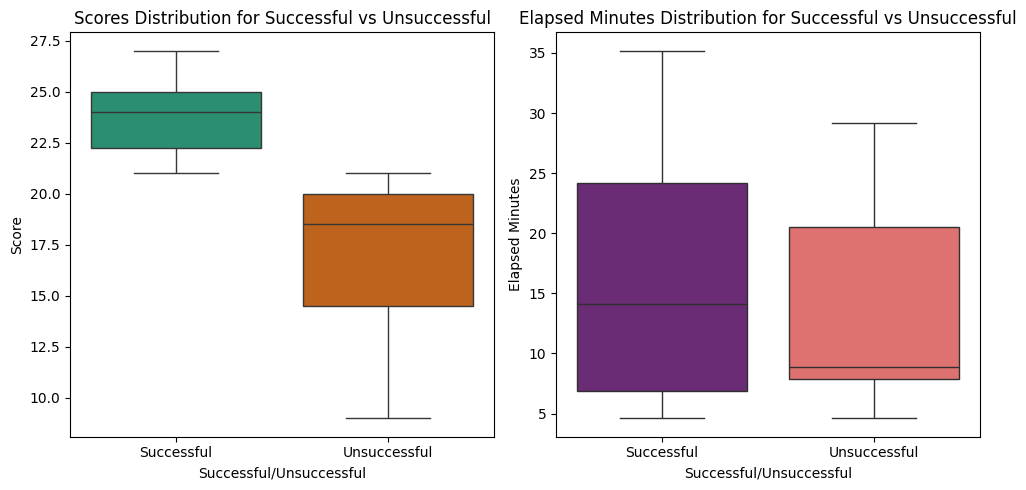

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()

sns.boxplot(data=df_all_results, x='Successful/Unsuccessful', y='Score', ax=ax[0], palette='Dark2')
ax[0].set_title("Scores Distribution for Successful vs Unsuccessful")

sns.boxplot(data=df_all_results, x='Successful/Unsuccessful', y='Elapsed Minutes', ax=ax[1], palette='magma')
ax[1].set_title("Elapsed Minutes Distribution for Successful vs Unsuccessful")

plt.tight_layout()
plt.show()

In [26]:
df_all_results.groupby('Successful/Unsuccessful')['Elapsed Minutes'].mean()

,Elapsed Minutes
Successful/Unsuccessful,
Successful,15.988437
Unsuccessful,13.706625


In [27]:
print('T-TEST ON ELAPSED MIUNTES OF SUCCESSES AND UNSUCCESSFUL')

succcessful_label_df = df_all_results[df_all_results['Successful/Unsuccessful'] == 'Successful']
unsucccessful_label_df = df_all_results[df_all_results['Successful/Unsuccessful'] == 'Unsuccessful']

alpha = 0.05
statistic, p_value = ttest_ind(succcessful_label_df['Elapsed Minutes'], unsucccessful_label_df['Elapsed Minutes'], equal_var=False)

print(f"(test-statistic = {statistic} | p-value = {p_value:.2f} | alpha = {alpha})", end='\n==> ')
if p_value < alpha:
    print(f"\033[32mReject the H0. There is a significant difference in Elapsed Minutes between success and unsuccessful.\033[0m")
else:
    print(f"Fail to reject H0. There is no significant difference in Elapsed Minutes between success and unsuccessful.")

T-TEST ON ELAPSED MIUNTES OF SUCCESSES AND UNSUCCESSFUL
(test-statistic = 0.8439819285173095 | p-value = 0.40 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in Elapsed Minutes between success and unsuccessful.


In [28]:
df_all_results.groupby('Successful/Unsuccessful')['Score'].mean()

,Score
Successful/Unsuccessful,
Successful,23.727273
Unsuccessful,16.950000


In [29]:
print('T-TEST ON SCORES OF SUCCESSES AND UNSUCCESSFUL')

alpha = 0.05
statistic, p_value = ttest_ind(succcessful_label_df['Score'], unsucccessful_label_df['Score'], equal_var=False)

print(f"(test-statistic = {statistic} | p-value = {p_value:.2e} | alpha = {alpha})", end='\n==> ')
if p_value < alpha:
    print(f"\033[32mReject the H0. There is a significant difference in Scores between success and unsuccessful.\033[0m")
else:
    print(f"Fail to reject H0. There is no significant difference in Scores Minutes between success and unsuccessful.")

T-TEST ON SCORES OF SUCCESSES AND UNSUCCESSFUL
(test-statistic = 7.444279979415541 | p-value = 7.15e-08 | alpha = 0.05)
==> Reject the H0. There is a significant difference in Scores between success and unsuccessful.


Judging from the histograms, seems like the participants who fail tend to finish their assessments faster than those who pass. This suggests them maybe skipping through questions as a result of not knowing how to answer them.In addition, we also see that the H-E group always tend to finish faster than the E-H group, regardless of whether they pass or fail (See 2nd and 3rd histogram). However, this hypothesis was rejected after running t-tests

# 1. Answering RQ1


**Are there significant differences in eye gaze and physiological biomarkers, when task difficulties are increased?**

---

## 1.1. T-Test Analyzing differences in Physiological Biomarkers between assessments

We will use the `ttest_ind()` method from `scipy.stats` module, letting $\alpha = 0.05$. This is a **parametric test** with $H_{0}$ that 2 **independent samples** have identical means. [Source](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#r3566833beaa2-1). NOTE: We will set the parameter `equal_var = False` which performs Welch's t-test, as we do not want to assume that both groups we are comparing have equal variances

In [ ]:
# Helper Function
def make_hypothesis(p_value, feature, groups, alpha=0.05, beta=0.25):
    print(f"(p-value = {p_value:.4f} | alpha = {alpha})", end='\n==> ')
    if p_value < alpha:
        print(f"\033[32mReject the H0. There is a significant difference in {feature} between {groups}.\033[0m")
        return 1
    else:
        if p_value < beta:
            print(f"Fail to reject H0. There is no significant difference in {feature} between {groups}. \033[33m(BUT CONSIDER LOOKING INTO THIS FEATURE MORE)\033[0m")
            return -1
        else:
            print(f"Fail to reject H0. There is no significant difference in {feature} between {groups}.")
        return 0

Extract median biometric values from EmbracePlus smartwatch data for two assessments, excluding participants with data loss, and store the results in DataFrames for analysis.

In [ ]:
EMBRACE_PLUS_FEATURES = ["eda_scl_usiemens", "pulse_rate_bpm", "temperature_celsius"]

In [ ]:
# Dictionary of each EmbracePlus biometric, collected by medians of each participant
easy_assessment_biometrics_dict = {}
hard_assessment_biometrics_dict = {}

for p in PARTICIPANTS:
    for diff in ['easy', 'hard']:
        df = pd.read_csv(os.path.join(MERGED_DATA, f"Participant {p}", f"participant{p}_{diff}_assessment.csv"))

        if diff == 'easy':
            if p in EASY_ASSESSMENT_EXCLUDE:
                continue # Excluded assessments (i.e ones with data loss)
            else:
                for feature in EMBRACE_PLUS_FEATURES:
                    if feature not in easy_assessment_biometrics_dict:
                        easy_assessment_biometrics_dict[feature] = []
                    easy_assessment_biometrics_dict[feature].append(df[feature].median())

        elif diff == 'hard':
            if p in HARD_ASSESSMENT_EXCLUDE:
                continue # Excluded assessments (i.e ones with data loss)
            else:
                for feature in EMBRACE_PLUS_FEATURES:
                    if feature not in hard_assessment_biometrics_dict:
                        hard_assessment_biometrics_dict[feature] = []
                    hard_assessment_biometrics_dict[feature].append(df[feature].median())

# Dataframe of median values per participant
df_aggregated_easy_biomarkers = pd.DataFrame(easy_assessment_biometrics_dict)
df_aggregated_hard_biomarkers = pd.DataFrame(hard_assessment_biometrics_dict)

In [ ]:
df_aggregated_easy_biomarkers.head()

,eda_scl_usiemens,pulse_rate_bpm,temperature_celsius
0,0.06,59.714286,28.846429
1,0.32,69.785714,30.749286
2,0.16,92.000000,31.802857
3,0.06,88.642857,29.338571
4,0.06,86.000000,30.662857


In [ ]:
df_aggregated_hard_biomarkers.head()

,eda_scl_usiemens,pulse_rate_bpm,temperature_celsius
0,0.07,57.714286,28.987143
1,0.42,70.714286,31.030000
2,0.18,90.000000,32.720000
3,0.06,90.714286,29.562857
4,0.07,81.857143,30.044286


In [ ]:
df_aggregated_hard_biomarkers.keys()

Index(['eda_scl_usiemens', 'pulse_rate_bpm', 'temperature_celsius'], dtype='object')

In [ ]:
p_values_biomarkers = {}

for feature in EMBRACE_PLUS_FEATURES:
    print(f"Variance of {feature} in EASY assessment: {df_aggregated_easy_biomarkers[feature].var():.2f}")
    print(f"Variance of {feature} in HARD assessment: {df_aggregated_hard_biomarkers[feature].var():.2f}")
    statistic, p_value = ttest_ind(df_aggregated_easy_biomarkers[feature], df_aggregated_hard_biomarkers[feature], equal_var=False)
    p_values_biomarkers[feature] = p_value
    make_hypothesis(p_value, feature, 'assessments')
    print('------------------------------------------------------------------')

Variance of eda_scl_usiemens in EASY assessment: 0.20
Variance of eda_scl_usiemens in HARD assessment: 0.05
(p-value = 0.3105 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in eda_scl_usiemens between assessments.
------------------------------------------------------------------
Variance of pulse_rate_bpm in EASY assessment: 80.67
Variance of pulse_rate_bpm in HARD assessment: 101.13
(p-value = 0.2971 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in pulse_rate_bpm between assessments.
------------------------------------------------------------------
Variance of temperature_celsius in EASY assessment: 3.63
Variance of temperature_celsius in HARD assessment: 4.65
(p-value = 0.4824 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in temperature_celsius between assessments.
------------------------------------------------------------------


In [ ]:
df_aggregated_easy_biomarkers['Assessment'] = 'Easy'
df_aggregated_hard_biomarkers['Assessment'] = 'Hard'

df_all_aggregated_biomarkers = pd.concat([df_aggregated_easy_biomarkers, df_aggregated_hard_biomarkers], axis=0)
df_all_aggregated_biomarkers = df_all_aggregated_biomarkers.reset_index(drop=True)

In [ ]:
df_all_aggregated_biomarkers.head()

,eda_scl_usiemens,pulse_rate_bpm,temperature_celsius,Assessment
0,0.06,59.714286,28.846429,Easy
1,0.32,69.785714,30.749286,Easy
2,0.16,92.000000,31.802857,Easy
3,0.06,88.642857,29.338571,Easy
4,0.06,86.000000,30.662857,Easy


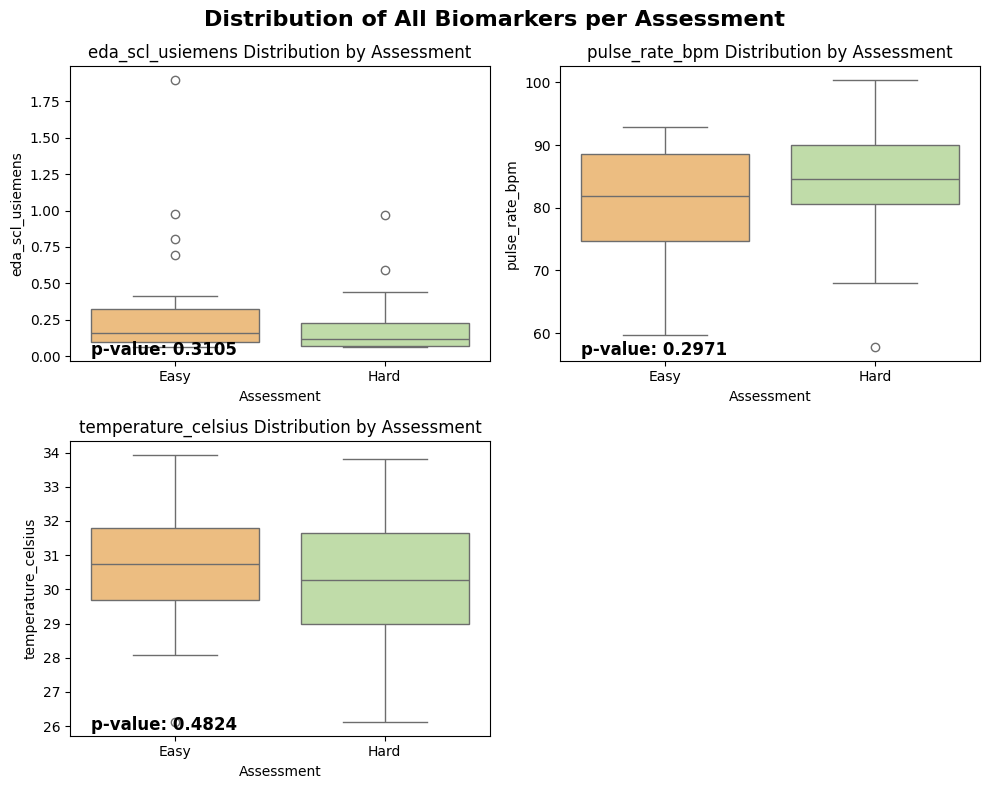

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()

for i, feature in enumerate(EMBRACE_PLUS_FEATURES):
    sns.boxplot(data=df_all_aggregated_biomarkers, x='Assessment', y=feature, palette='Spectral', ax=ax[i])
    ax[i].set_title(f"{feature} Distribution by Assessment")

    # Get y-axis limits to position text at the bottom-left corner
    ymin, ymax = ax[i].get_ylim()

    value = p_values_biomarkers[feature]
    # Add annotation in the bottom-left corner
    ax[i].text(-0.4, ymin + (ymax - ymin) * 0.02,  # Small offset above min y-value
                f"p-value: {value:.4f}",
                ha='left', fontsize=12, fontweight='bold', color='black')

fig.delaxes(ax[3])

fig.suptitle("Distribution of All Biomarkers per Assessment", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 1.2. T-Test Analyzing differences in DGMs between assessments

Extract median descriptive gaze measure values from Gazepoint each assessment, excluding participants with data loss, and store the results in DataFrames for analysis.

In [ ]:
ALL_GAZEPOINT_DGM_FEATURES = list(pd.read_csv('/content/drive/MyDrive/CECS 698 - Data Analysis/Merged Data/Participant 10/participant10_easy_assessment.csv').columns)[4:]

In [ ]:
# Dictionary of each Gazepoint descriptive gaze measures, collected by medians of each participant
easy_assessment_DGM_dict = {}
hard_assessment_DGM_dict = {}

for p in PARTICIPANTS:
    for diff in ['easy', 'hard']:
        df = pd.read_csv(os.path.join(MERGED_DATA, f"Participant {p}", f"participant{p}_{diff}_assessment.csv"))

        if diff == 'easy':
            if p in EASY_ASSESSMENT_EXCLUDE:
                continue # Excluded assessments (i.e ones with data loss)
            else:
                for feature in ALL_GAZEPOINT_DGM_FEATURES:
                    if feature not in easy_assessment_DGM_dict:
                        easy_assessment_DGM_dict[feature] = []
                    easy_assessment_DGM_dict[feature].append(df[feature].median())

        elif diff == 'hard':
            if p in HARD_ASSESSMENT_EXCLUDE:
                continue # Excluded assessments (i.e ones with data loss)
            else:
                for feature in ALL_GAZEPOINT_DGM_FEATURES:
                    if feature not in hard_assessment_DGM_dict:
                        hard_assessment_DGM_dict[feature] = []
                    hard_assessment_DGM_dict[feature].append(df[feature].median())

# Dataframe of median values per participant
df_aggregated_easy_DGM = pd.DataFrame(easy_assessment_DGM_dict)
df_aggregated_hard_DGM = pd.DataFrame(hard_assessment_DGM_dict)

In [ ]:
df_aggregated_easy_DGM.head()

,total_number_of_fixations,sum_of_all_fixation_duration_s,mean_fixation_duration_s,median_fixation_duration_s,stdev_of_fixation_durations_s,min_fixation_duration_s,max_fixation_duration_s,total_number_of_saccades,sum_of_all_saccade_lengths,mean_saccade_length,...,max_relative_degree,convex_hull_area,stationary_entropy,transition_entropy,total_number_of_blinks,average_blink_rate_per_minute,total_number_of_valid_recordings,average_pupil_size_of_left_eye,average_pupil_size_of_right_eye,average_pupil_size_of_both_eyes
0,5.25,1.315135,0.275186,0.234560,0.154696,0.094600,0.523130,3.0,324.526315,91.313063,...,149.430242,50140.115597,0.0,0.0,1.00,6.003692,234.0,3.184172,3.124978,3.152975
1,41.00,9.569990,0.235207,0.214187,0.120912,0.087160,0.599930,39.0,3448.941323,89.684927,...,171.661929,87606.259379,0.0,0.0,0.50,3.001842,1477.5,3.248416,3.176852,3.214106
2,28.00,9.170840,0.337565,0.276757,0.187347,0.099120,0.872218,25.5,2380.217798,93.968126,...,173.721147,83826.009855,0.0,0.0,1.75,10.506061,1446.0,3.512113,3.463205,3.487456
3,26.00,9.322265,0.345178,0.281250,0.232415,0.085940,0.994140,23.5,2679.646354,105.017097,...,173.519736,68118.795193,0.0,0.0,1.00,6.004690,1438.0,3.421694,3.323279,3.371246
4,45.00,8.669937,0.186993,0.164060,0.082257,0.027345,0.425785,43.0,3755.391268,91.171564,...,168.593686,119719.252143,0.0,0.0,1.00,6.004690,1407.5,3.019859,3.193729,3.099295


In [ ]:
df_aggregated_hard_DGM.head()

,total_number_of_fixations,sum_of_all_fixation_duration_s,mean_fixation_duration_s,median_fixation_duration_s,stdev_of_fixation_durations_s,min_fixation_duration_s,max_fixation_duration_s,total_number_of_saccades,sum_of_all_saccade_lengths,mean_saccade_length,...,max_relative_degree,convex_hull_area,stationary_entropy,transition_entropy,total_number_of_blinks,average_blink_rate_per_minute,total_number_of_valid_recordings,average_pupil_size_of_left_eye,average_pupil_size_of_right_eye,average_pupil_size_of_both_eyes
0,26.0,8.506110,0.310194,0.254390,0.205065,0.080570,0.891360,22.0,2308.793912,106.869137,...,165.102815,85342.153755,0.0,0.0,0.5,3.001687,1346.0,3.426875,3.426317,3.427194
1,32.0,9.675675,0.302208,0.254790,0.170763,0.093750,0.852235,30.5,3029.129583,100.384198,...,169.763067,67249.989867,0.0,0.0,1.0,6.003444,1470.0,3.395896,3.422622,3.397803
2,31.0,9.440555,0.303732,0.254390,0.194590,0.092775,0.914245,29.0,2639.512758,94.654111,...,167.031211,74202.066680,0.0,0.0,1.5,9.007479,1443.0,3.654954,3.505221,3.579619
3,29.0,9.300810,0.320986,0.265625,0.192153,0.097660,0.878910,27.0,2394.948293,98.257190,...,168.110936,75799.415347,0.0,0.0,1.0,6.004690,1450.0,3.411524,3.254988,3.328894
4,35.0,9.347670,0.264394,0.234380,0.139864,0.085940,0.695312,32.5,2986.058695,92.170044,...,169.808068,95555.732348,0.0,0.0,1.0,6.004690,1444.0,3.104321,3.194732,3.147019


In [ ]:
important_DGM_features = {}
slightly_important_DGM_features = {}

for feature in ALL_GAZEPOINT_DGM_FEATURES:
    print(f"Variance of {feature} in EASY assessment: {df_aggregated_easy_DGM[feature].var():.2f}")
    print(f"Variance of {feature} in HARD assessment: {df_aggregated_hard_DGM[feature].var():.2f}")
    statistic, p_value = ttest_ind(df_aggregated_easy_DGM[feature], df_aggregated_hard_DGM[feature], equal_var=False)
    result = make_hypothesis(p_value, feature, 'assessments')
    if result == 1:
        important_DGM_features[feature] = p_value
    if result == -1:
        slightly_important_DGM_features[feature] = p_value

    print('------------------------------------------------------------------')

Variance of total_number_of_fixations in EASY assessment: 122.88
Variance of total_number_of_fixations in HARD assessment: 30.70
(p-value = 0.3673 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in total_number_of_fixations between assessments.
------------------------------------------------------------------
Variance of sum_of_all_fixation_duration_s in EASY assessment: 5.43
Variance of sum_of_all_fixation_duration_s in HARD assessment: 3.65
(p-value = 0.6965 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in sum_of_all_fixation_duration_s between assessments.
------------------------------------------------------------------
Variance of mean_fixation_duration_s in EASY assessment: 0.00
Variance of mean_fixation_duration_s in HARD assessment: 0.00
(p-value = 0.3210 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in mean_fixation_duration_s between assessments.
-----------------------------------------------

In [ ]:
list(important_DGM_features.keys())

['mean_absolute_degree',
 'median_absolute_degree',
 'stdev_of_absolute_degrees',
 'mean_relative_degree',
 'median_relative_degree',
 'average_pupil_size_of_left_eye']

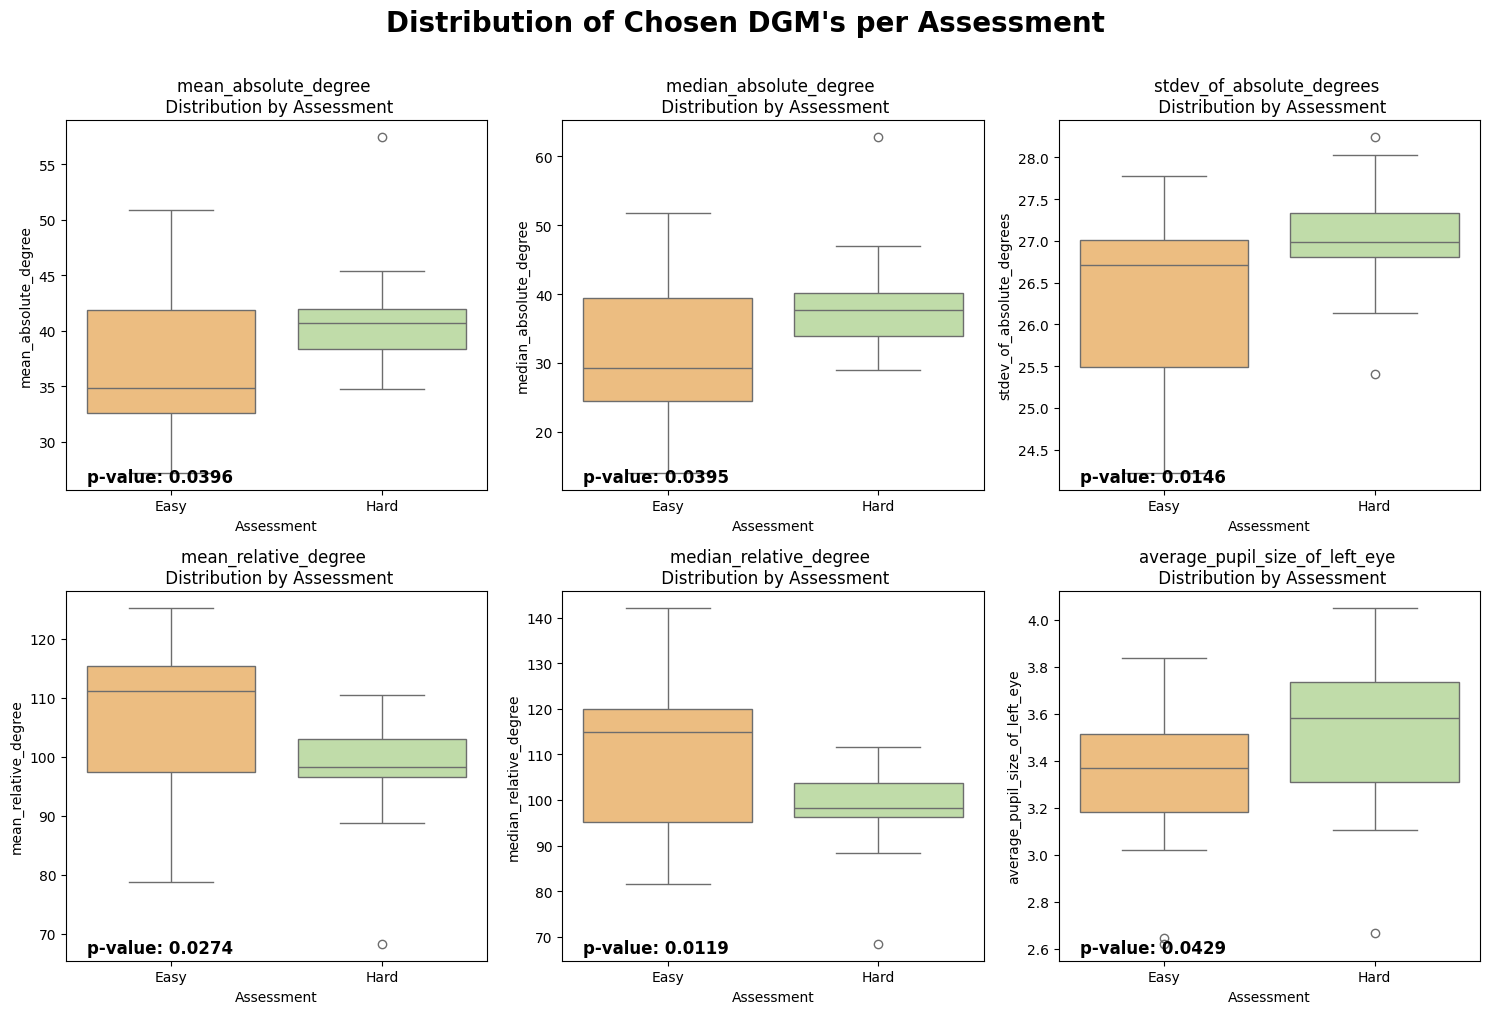

In [ ]:
# Add 'Assessment' column to differentiate between easy and hard groups
df_aggregated_easy_DGM['Assessment'] = 'Easy'
df_aggregated_hard_DGM['Assessment'] = 'Hard'

# Combine both datasets
df_all_aggregated_DGM = pd.concat([df_aggregated_easy_DGM, df_aggregated_hard_DGM], axis=0)
df_all_aggregated_DGM = df_all_aggregated_DGM.reset_index(drop=True)

# Create subplots
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()

# Iterate through features and create boxplots
for i, (feature, value) in enumerate(important_DGM_features.items()):
    sns.boxplot(data=df_all_aggregated_DGM, x='Assessment', y=feature, palette='Spectral', ax=ax[i])
    ax[i].set_title(f"{feature} \n Distribution by Assessment")

    # Get y-axis limits to position text at the bottom-left corner
    ymin, ymax = ax[i].get_ylim()

    # Add annotation in the bottom-left corner
    ax[i].text(-0.4, ymin + (ymax - ymin) * 0.02,  # Small offset above min y-value
               f"p-value: {value:.4f}",
               ha='left', fontsize=12, fontweight='bold', color='black')

# Remove extra unused subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

# Set main title
fig.suptitle("Distribution of Chosen DGM's per Assessment", fontsize=20, fontweight='bold', y=1.01)

plt.tight_layout()
plt.show()


In [ ]:
list(slightly_important_DGM_features.keys())

['stdev_of_fixation_durations_s',
 'max_fixation_duration_s',
 'mean_saccade_length',
 'median_saccade_length',
 'stdev_of_saccade_lengths',
 'mean_saccade_duration',
 'mean_saccade_amplitude',
 'median_saccade_amplitude',
 'stdev_of_saccade_amplitude',
 'std_peak_saccade_velocity',
 'std_mean_saccade_velocity',
 'max_absolute_degree',
 'sum_of_all_relative_degrees',
 'min_relative_degree',
 'average_pupil_size_of_right_eye',
 'average_pupil_size_of_both_eyes']

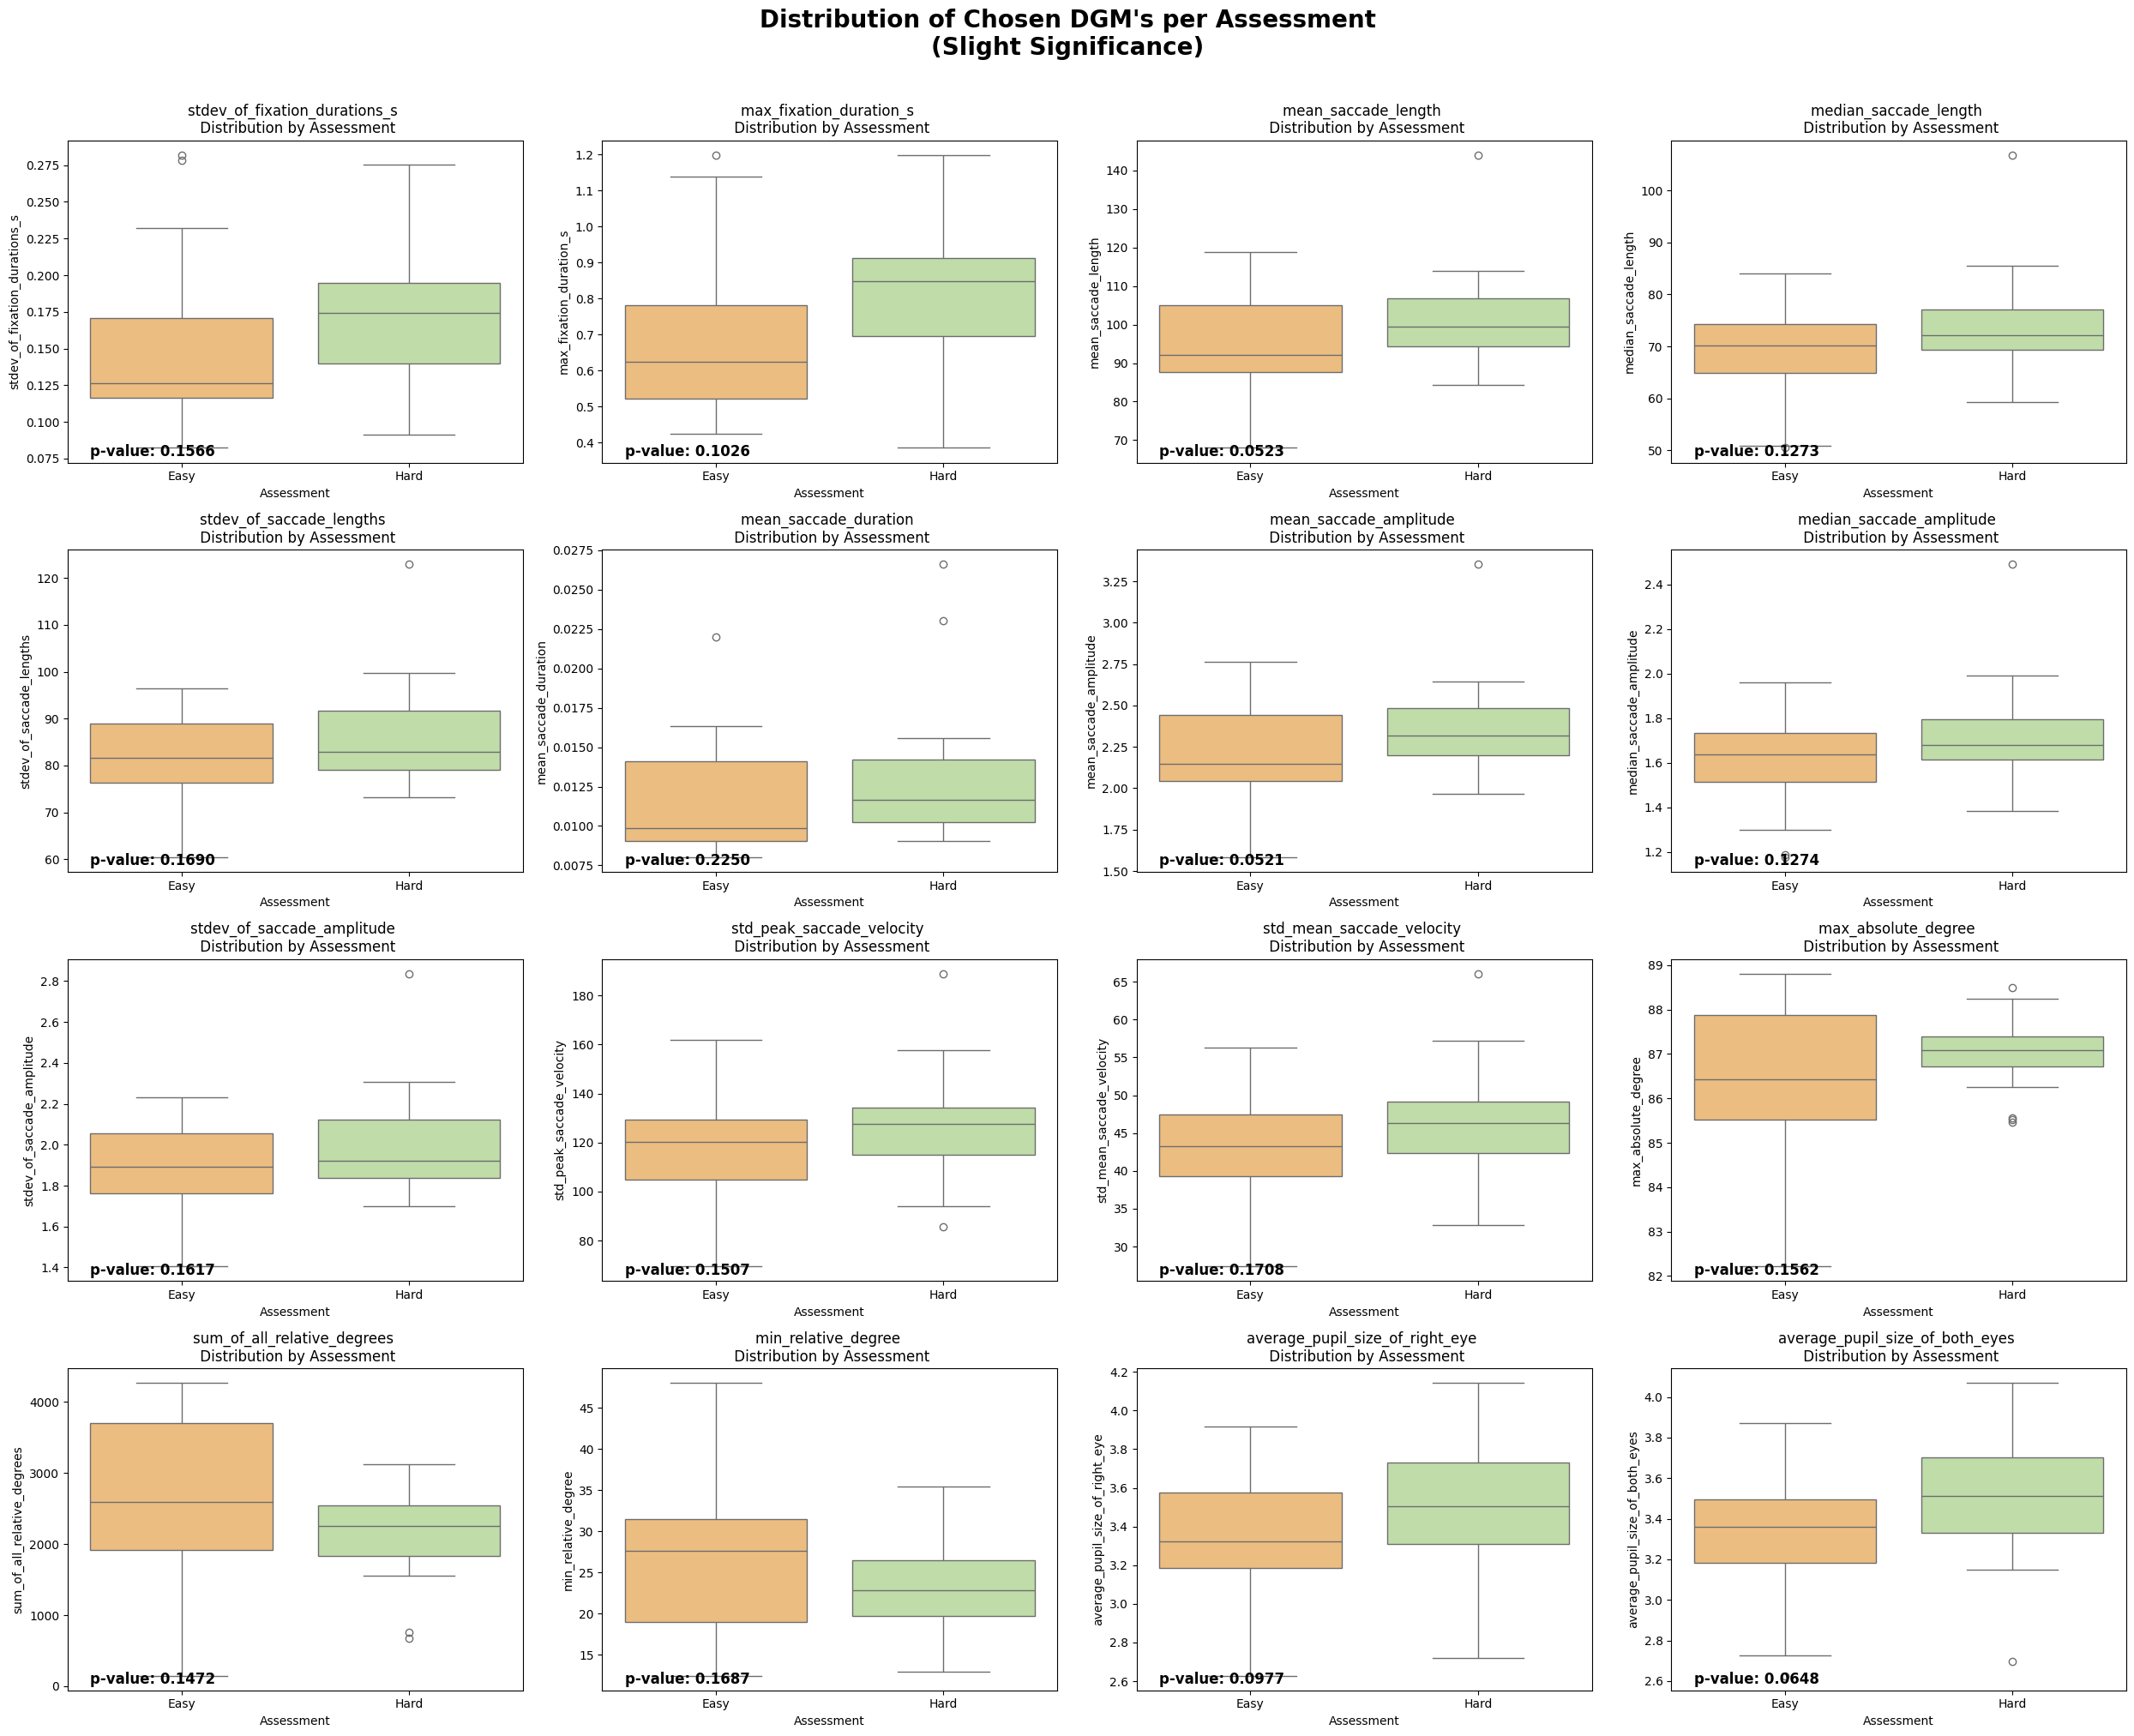

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(25, 20))
ax = ax.flatten()

for i, (feature, value) in enumerate(slightly_important_DGM_features.items()):
    sns.boxplot(data=df_all_aggregated_DGM, x='Assessment', y=feature, palette='Spectral', ax=ax[i])
    ax[i].set_title(f"{feature} \n Distribution by Assessment")

    # Get y-axis limits to position text at the bottom-left corner
    ymin, ymax = ax[i].get_ylim()

    # Add annotation in the bottom-left corner
    ax[i].text(-0.4, ymin + (ymax - ymin) * 0.02,  # Small offset above min y-value
               f"p-value: {value:.4f}",
               ha='left', fontsize=12, fontweight='bold', color='black')

# Remove extra unused subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

fig.suptitle("Distribution of Chosen DGM's per Assessment\n(Slight Significance)", fontsize=20, fontweight='bold', y=1.01)

plt.tight_layout()
plt.show()

# 2. Answering RQ2

**Are notable tendencies evident in eye gaze, physiological biomarkers, for those who are more successful compared to those who are less successful?**

---


## 2.1. T-Test Analyzing differences in Physiological Biomarkers between success/failure

In [ ]:
# Getting all dataframes and splitting them into 2 groups: Successful and Unsuccessful
groups_split_by_success = {
    'Successful': [],
    'Unsuccessful': []
}

for p in PARTICIPANTS:
    for diff in ['easy', 'hard']:
        if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
            continue # Excluded assessments (i.e ones with data loss)

        df = pd.read_csv(os.path.join(MERGED_DATA, f"Participant {p}", f"participant{p}_{diff}_assessment.csv"))
        label = df_all_results[(df_all_results['Participant ID '] == p) & (df_all_results['Assessment'] == diff)]['Successful/Unsuccessful'].values[0]
        df['Participant'] = p
        df['Successful/Unsuccessful'] = label
        groups_split_by_success[label].append(df)


In [ ]:
# Aggregating median biomarker value per participant
successful_biomarkers = {}
unsuccessful_biomarkers = {}

# Getting median biomarkers of each participant who succeeded
for data in groups_split_by_success['Successful']:
    for feature in EMBRACE_PLUS_FEATURES:
        if feature not in successful_biomarkers:
            successful_biomarkers[feature] = []
        successful_biomarkers[feature].append(data[feature].median())

# Getting median biomarkers of each participant who did not succeed
for data in groups_split_by_success['Unsuccessful']:
    for feature in EMBRACE_PLUS_FEATURES:
        if feature not in unsuccessful_biomarkers:
            unsuccessful_biomarkers[feature] = []
        unsuccessful_biomarkers[feature].append(data[feature].median())


# Dataframe of median values per participant
df_aggregated_successful_biomarkers = pd.DataFrame(successful_biomarkers)
df_aggregated_unsuccessful_biomarkers = pd.DataFrame(unsuccessful_biomarkers)

df_aggregated_successful_biomarkers['Successful/Unsuccessful'] = 'Successful'
df_aggregated_unsuccessful_biomarkers['Successful/Unsuccessful'] = 'Unsuccessful'

In [ ]:
p_values_biomarkers = {}

for feature in EMBRACE_PLUS_FEATURES:
    print(f"Variance of {feature} in SUCCESSFUL groups: {df_aggregated_successful_biomarkers[feature].var():.2f}")
    print(f"Variance of {feature} in UNSUCCESSFUL groups: {df_aggregated_unsuccessful_biomarkers[feature].var():.2f}")
    statistic, p_value = ttest_ind(df_aggregated_successful_biomarkers[feature], df_aggregated_unsuccessful_biomarkers[feature], equal_var=False)
    p_values_biomarkers[feature] = p_value
    make_hypothesis(p_value, feature, 'success/failure')
    print('------------------------------------------------------------------')

Variance of eda_scl_usiemens in SUCCESSFUL groups: 0.07
Variance of eda_scl_usiemens in UNSUCCESSFUL groups: 0.19
(p-value = 0.9598 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in eda_scl_usiemens between success/failure.
------------------------------------------------------------------
Variance of pulse_rate_bpm in SUCCESSFUL groups: 107.06
Variance of pulse_rate_bpm in UNSUCCESSFUL groups: 66.11
(p-value = 0.1070 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in pulse_rate_bpm between success/failure. (BUT CONSIDER LOOKING INTO THIS FEATURE MORE)
------------------------------------------------------------------
Variance of temperature_celsius in SUCCESSFUL groups: 3.73
Variance of temperature_celsius in UNSUCCESSFUL groups: 4.47
(p-value = 0.3148 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in temperature_celsius between success/failure.
-------------------------------------------------------------

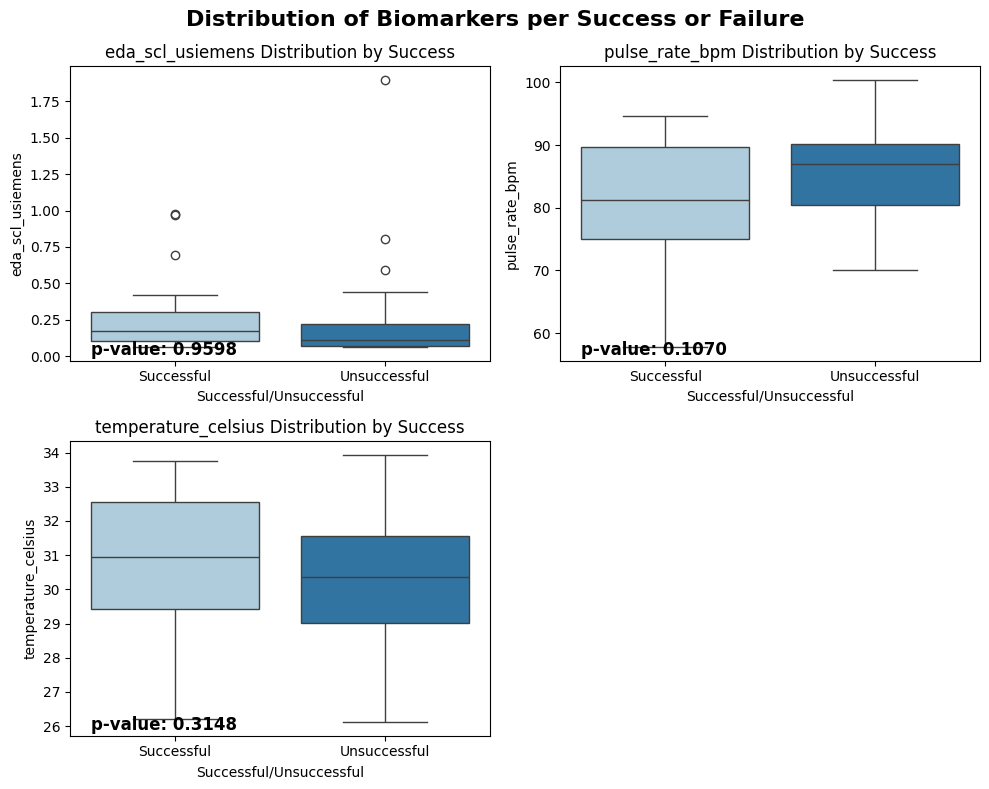

In [ ]:
df_all_aggregated_biomarkers = pd.concat([df_aggregated_successful_biomarkers, df_aggregated_unsuccessful_biomarkers], axis=0).reset_index(drop=True)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()

for i, feature in enumerate(EMBRACE_PLUS_FEATURES):
    sns.boxplot(data=df_all_aggregated_biomarkers, x='Successful/Unsuccessful', y=feature, palette='Paired', ax=ax[i])
    ax[i].set_title(f"{feature} Distribution by Success")

     # Get y-axis limits to position text at the bottom-left corner
    ymin, ymax = ax[i].get_ylim()

    value = p_values_biomarkers[feature]
    # Add annotation in the bottom-left corner
    ax[i].text(-0.4, ymin + (ymax - ymin) * 0.02,  # Small offset above min y-value
                f"p-value: {value:.4f}",
                ha='left', fontsize=12, fontweight='bold', color='black')

fig.delaxes(ax[3])

fig.suptitle("Distribution of Biomarkers per Success or Failure", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.2. T-Test Analyzing differences in DGMs between success/failure

In [ ]:
# Aggregating median biomarker value per participant
successful_DGM = {}
unsuccessful_DGM = {}

# Getting median biomarkers of each participant who succeeded
for data in groups_split_by_success['Successful']:
    for feature in ALL_GAZEPOINT_DGM_FEATURES:
        if feature not in successful_DGM:
            successful_DGM[feature] = []
        successful_DGM[feature].append(data[feature].median())

# Getting median biomarkers of each participant who did not succeed
for data in groups_split_by_success['Unsuccessful']:
    for feature in ALL_GAZEPOINT_DGM_FEATURES:
        if feature not in unsuccessful_DGM:
            unsuccessful_DGM[feature] = []
        unsuccessful_DGM[feature].append(data[feature].median())


# Dataframe of median values per participant
df_aggregated_successful_DGM = pd.DataFrame(successful_DGM)
df_aggregated_unsuccessful_DGM = pd.DataFrame(unsuccessful_DGM)

df_aggregated_successful_DGM['Successful/Unsuccessful'] = 'Successful'
df_aggregated_unsuccessful_DGM['Successful/Unsuccessful'] = 'Unsuccessful'

In [ ]:
important_DGM_features2 = {}
slightly_important_DGM_features2 = {}

for feature in ALL_GAZEPOINT_DGM_FEATURES:
    print(f"Variance of {feature} in SUCCESSFUL groups: {df_aggregated_successful_DGM[feature].var():.2f}")
    print(f"Variance of {feature} in UNSUCCESSFUL groups: {df_aggregated_unsuccessful_DGM[feature].var():.2f}")
    statistic, p_value = ttest_ind(df_aggregated_successful_DGM[feature], df_aggregated_unsuccessful_DGM[feature], equal_var=False)
    result = make_hypothesis(p_value, feature, 'success/failure', beta=0.1)
    if result == 1:
        important_DGM_features2[feature] = p_value
    if result == -1:
        slightly_important_DGM_features2[feature] = p_value
    print('------------------------------------------------------------------')

Variance of total_number_of_fixations in SUCCESSFUL groups: 78.99
Variance of total_number_of_fixations in UNSUCCESSFUL groups: 76.39
(p-value = 0.5667 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in total_number_of_fixations between success/failure.
------------------------------------------------------------------
Variance of sum_of_all_fixation_duration_s in SUCCESSFUL groups: 4.77
Variance of sum_of_all_fixation_duration_s in UNSUCCESSFUL groups: 4.28
(p-value = 0.6769 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in sum_of_all_fixation_duration_s between success/failure.
------------------------------------------------------------------
Variance of mean_fixation_duration_s in SUCCESSFUL groups: 0.00
Variance of mean_fixation_duration_s in UNSUCCESSFUL groups: 0.00
(p-value = 0.1288 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in mean_fixation_duration_s between success/failure.
------------------

In [ ]:
important_DGM_features2

{}

In [ ]:
list(slightly_important_DGM_features2.keys())

['stdev_of_fixation_durations_s', 'max_fixation_duration_s']

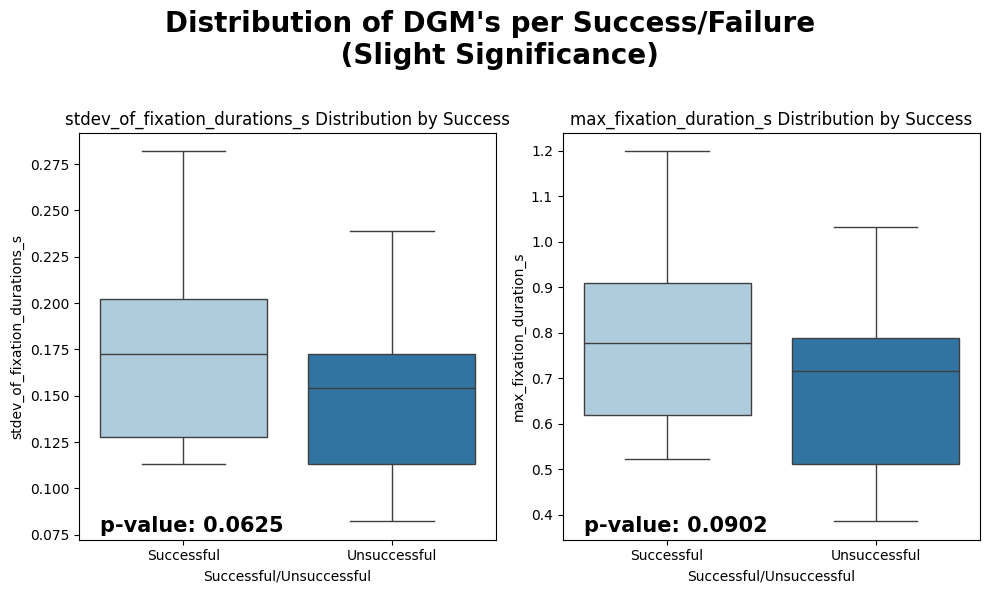

In [ ]:
df_all_aggregated_DGM = pd.concat([df_aggregated_successful_DGM, df_aggregated_unsuccessful_DGM], axis=0).reset_index(drop=True)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

for i, feature in enumerate(slightly_important_DGM_features2):
    sns.boxplot(data=df_all_aggregated_DGM, x='Successful/Unsuccessful', y=feature, palette='Paired', ax=ax[i])
    ax[i].set_title(f"{feature} Distribution by Success")

    # Get y-axis limits to position text at the bottom-left corner
    ymin, ymax = ax[i].get_ylim()

    value = slightly_important_DGM_features2[feature]
    # Add annotation in the bottom-left corner
    ax[i].text(-0.4, ymin + (ymax - ymin) * 0.02,  # Small offset above min y-value
                f"p-value: {value:.4f}",
                ha='left', fontsize=15, fontweight='bold', color='black')

# Remove extra unused subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])


fig.suptitle("Distribution of DGM's per Success/Failure \n (Slight Significance)", fontsize=20, fontweight='bold', y=1.01)

plt.tight_layout()
plt.show()

There seems to be a slight pattern in specific DGM's when comparing Successful and Unsuccessful participants.  

Analyzing raw gaze data per participant (Random sample of individual participants)

In [ ]:
BPOG_scanpaths = os.path.join(CECS_698_PATH, 'BPOG Scanpaths')
if not os.path.exists(BPOG_scanpaths):
    print(f"{BPOG_scanpaths} successfully created")
    os.makedirs(BPOG_scanpaths)
else:
    print(f"{BPOG_scanpaths} already exists")

FPOG_scanpaths = os.path.join(CECS_698_PATH, 'FPOG Scanpaths')
if not os.path.exists(FPOG_scanpaths):
    print(f"{FPOG_scanpaths} successfully created")
    os.makedirs(FPOG_scanpaths)
else:
    print(f"{FPOG_scanpaths} already exists")

/content/drive/MyDrive/CECS 698 - Data Analysis/BPOG Scanpaths already exists
/content/drive/MyDrive/CECS 698 - Data Analysis/FPOG Scanpaths already exists


Helper functions to generate images:

In [ ]:
def plot_BPOG_scanpath(df, save_path, fig_width=5, fig_height=5):
    plt.figure(figsize=(fig_width, fig_height), facecolor='black')

    # Plot scanpath in white
    plt.plot(df['BPOGX'], df['BPOGY'], marker='o', linestyle='-', color='white',
             markersize=4, alpha=0.7)

    # Remove ticks, labels, and borders
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')  # Completely removes axes and borders
    plt.gca().set_facecolor('black')  # Set axes background to black

    # Invert Y-axis for consistency with screen coordinates
    plt.gca().invert_yaxis()

    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=300, facecolor='black')
    plt.close()  # Close the figure to free memory
    print(f"Scanpath saved to: {save_path}")


def plot_FPOG_scanpath(df, save_path, fig_width=5, fig_height=5):
    plt.figure(figsize=(fig_width, fig_height), facecolor='black')

    # Plot fixations as white dots
    plt.scatter(df['FPOGX'], df['FPOGY'], color='white', s=40, alpha=0.7)

    # Remove ticks, labels, and borders
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')  # Completely removes axes and borders
    plt.gca().set_facecolor('black')  # Set axes background to black

    # Invert Y-axis for consistency with screen coordinates
    plt.gca().invert_yaxis()

    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=300, facecolor='black')
    plt.close()  # Close the figure to free memory
    print(f"Scanpath saved to: {save_path}")


Analyzing scanpaths for `BPOG` - Best Point of Gaze

In [ ]:
# for p in PARTICIPANTS:
#     # Creating participant folder if not exists
#     folder = os.path.join(BPOG_scanpaths, f"Participant {p}")
#     if not os.path.exists(folder):
#         os.makedirs(folder)

#     for diff in ['easy', 'hard']:
#         df_all_gaze_trimmed = pd.read_csv(os.path.join(GAZEPOINT_TRIMMED_PATH, f"Participant {p}", f"all_gaze_{diff}.csv"))
#         plot_BPOG_scanpath(df_all_gaze_trimmed, os.path.join(folder, f"BPOG {diff}.png"))

Analyzing scanpaths for `FPOG` - Fixation Point of Gaze

In [ ]:
# for p in PARTICIPANTS:
#     # Creating participant folder if not exists
#     folder = os.path.join(FPOG_scanpaths, f"Participant {p}")
#     if not os.path.exists(folder):
#         os.makedirs(folder)

#     for diff in ['easy', 'hard']:
#         df_all_gaze_trimmed = pd.read_csv(os.path.join(GAZEPOINT_TRIMMED_PATH, f"Participant {p}", f"all_gaze_{diff}.csv"))
#         plot_FPOG_scanpath(df_all_gaze_trimmed, os.path.join(folder, f"FPOG {diff}.png"))

In [ ]:
def view_scanpath(label, type, pairs_sample, img_width=200, img_height=200, spacing=10):
    print(f"Random sample of {len(pairs_sample)} participants/assessments who were {label}")

    images = []  # List to store images for horizontal concatenation

    for id, diff in pairs_sample:
        # Load the image
        if type == 'BPOG':
            image_path = os.path.join(BPOG_scanpaths, f"Participant {id}", f"BPOG {diff}.png")
        else:
            image_path = os.path.join(FPOG_scanpaths, f"Participant {id}", f"FPOG {diff}.png")
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is None:
            print(f"Error: Could not load image: {image_path}")
            continue  # Skip to the next image

        # Resize image
        resized_image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)

        # Add a title to the image (Participant ID and Assessment)
        title_text = f"ID: {id}, A: {diff}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.45  # Smaller font size
        font_thickness = 1
        text_color = (255, 255, 255)  # White color for visibility

        # Determine text size
        (text_width, text_height), _ = cv2.getTextSize(title_text, font, font_scale, font_thickness)

        # Create a title bar (a black rectangle above the image)
        title_bar = np.zeros((text_height + 8, img_width, 3), dtype=np.uint8)  # Adjusted padding
        cv2.putText(title_bar, title_text, (5, text_height + 2), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

        # Stack title above the image
        image_with_title = np.vstack([title_bar, resized_image])

        # Append image to the list
        images.append(image_with_title)

        # Add spacing (blank image) between images
        if spacing > 0:
            spacer = np.ones((image_with_title.shape[0], spacing, 3), dtype=np.uint8) * 255  # White space
            images.append(spacer)

    # If at least one image was loaded, concatenate and display
    if images:
        # Remove the last spacer to prevent extra spacing at the end
        if spacing > 0:
            images = images[:-1]

        # Concatenate images horizontally
        concatenated_image = np.hstack(images)

        # Display the concatenated image
        cv2_imshow(concatenated_image)
    else:
        print("No images could be loaded.")


In [ ]:
sample_size = 4

successful_pairs_sample = df_all_results[df_all_results['Successful/Unsuccessful'] == 'Successful'][['Participant ID ', 'Assessment']].sample(sample_size).values.tolist()
unsuccessful_pairs_sample = df_all_results[df_all_results['Successful/Unsuccessful'] == 'Unsuccessful'][['Participant ID ', 'Assessment']].sample(sample_size).values.tolist()

Random sample of 4 participants/assessments who were Successful


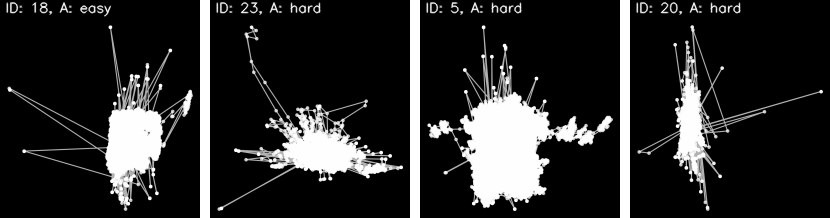


Random sample of 4 participants/assessments who were Successful


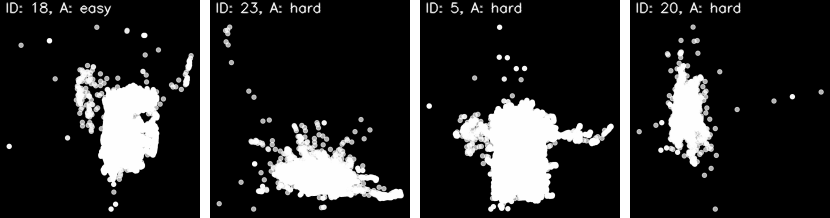

In [ ]:
view_scanpath('Successful', 'BPOG', successful_pairs_sample)
print()
view_scanpath('Successful', 'FPOG', successful_pairs_sample)

Random sample of 4 participants/assessments who were Unsuccessful


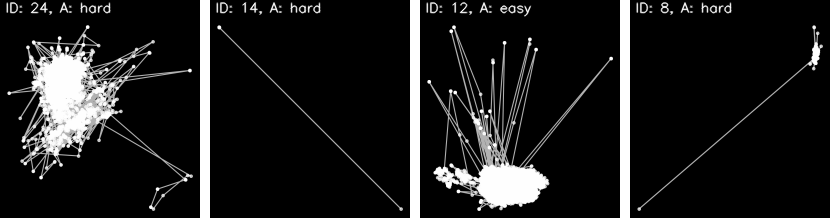


Random sample of 4 participants/assessments who were Unsuccessful


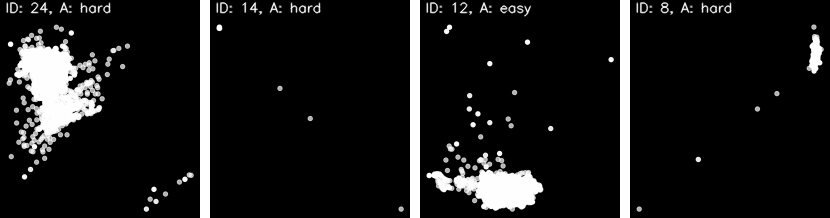

In [ ]:
view_scanpath('Unsuccessful', 'BPOG', unsuccessful_pairs_sample)
print()
view_scanpath('Unsuccessful', 'FPOG', unsuccessful_pairs_sample)

# 3. Answering RQ3

**Can physiological signals obtained from the eye, heart, and skin be indicative of levels of mental workload and fatigue?**

---


In [ ]:
pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - NASA TLX.csv')).columns

Index(['Timestamp',
       'What is your participant ID? (This will be given to you by your researcher) ',
       '1. Mental Demand - How mentally demanding was the task?',
       '2. Physical Demand - How physically demanding was the task?',
       '3. Temporal Demand - How hurried or rushed was the pace of the task?',
       '4. Performance - How successful were you in accomplishing what you were asked to do?',
       '5. Effort - How hard did you have to work to accomplish your level of performance?',
       '6. Frustration - How insecure, discouraged, irritated, stressed, and annoyed were you?',
       'Dry Run?'],
      dtype='object')

In [ ]:
# # Helper Function to compute p-values for Pearson correlation
# def pearson_p_values(df):
#     cols = df.columns
#     p_values = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

#     for col1 in cols:
#         for col2 in cols:
#             if col1 != col2:
#                 _, p = pearsonr(df[col1], df[col2])  # Compute Pearson r and p-value
#                 p_values.loc[col1, col2] = p

#     return p_values

## NASA TLX - Measures Mental Workload

In [ ]:
df_NASA_TLX = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - NASA TLX.csv'))#.drop('Dry Run?', axis=1)

df_NASA_TLX.columns = [
    'Timestamp',
    'Participant ID',
    'Mental Demand', # 1
    'Physical Demand', # 2
    'Temporal Demand', # 3
    'Performance', # 4
    'Effort', # 5
    'Frustration', # 6
    'Dry Run', # 7
]

df_NASA_TLX = df_NASA_TLX[df_NASA_TLX['Dry Run'].isnull()] # Take out dry run participants
df_NASA_TLX.drop(['Dry Run', 'Timestamp'], axis=1, inplace=True)
df_NASA_TLX.head()

,Participant ID,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration
3,4,6,7,1,7,5,3
4,5,6,1,2,4,5,6
5,6,3,5,2,6,4,2
6,7,5,1,4,5,4,3
7,8,5,1,2,4,5,3


In [ ]:
df_NASA_TLX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 3 to 25
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Participant ID   23 non-null     int64
 1   Mental Demand    23 non-null     int64
 2   Physical Demand  23 non-null     int64
 3   Temporal Demand  23 non-null     int64
 4   Performance      23 non-null     int64
 5   Effort           23 non-null     int64
 6   Frustration      23 non-null     int64
dtypes: int64(7)
memory usage: 1.4 KB


In [ ]:
df_NASA_TLX.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Participant ID,23.0,15.000000,6.782330,4.0,9.5,15.0,20.5,26.0
Mental Demand,23.0,4.608696,0.988071,3.0,4.0,5.0,5.0,6.0
Physical Demand,23.0,2.565217,1.674029,1.0,1.0,2.0,3.0,7.0
Temporal Demand,23.0,3.043478,1.296087,1.0,2.0,3.0,4.0,6.0
Performance,23.0,5.130435,1.324742,3.0,4.0,5.0,6.0,7.0
Effort,23.0,4.130435,1.140349,2.0,3.0,4.0,5.0,6.0
Frustration,23.0,3.000000,1.678744,1.0,2.0,3.0,4.0,6.0


In [ ]:
all_physiological_columns = pd.read_csv('/content/drive/MyDrive/CECS 698 - Data Analysis/Merged Data/Participant 10/participant10_easy_assessment.csv').columns.tolist()
all_physiological_columns.remove('timestamp_unix')

# Getting all dataframes in Merged Data directory, but only getting biomarker features.
df_all_physiological_data = []


for p in PARTICIPANTS:
    for diff in ['easy', 'hard']:
        if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
            continue # Excluded assessments (i.e ones with data loss)

        df = pd.read_csv(os.path.join(MERGED_DATA, f"Participant {p}", f"participant{p}_{diff}_assessment.csv"))[all_physiological_columns]
        df['Participant ID'] = p
        df = pd.merge(df, df_NASA_TLX, on='Participant ID', how='inner')
        df_all_physiological_data.append(df)

df_all_physiological_data = pd.concat(df_all_physiological_data, axis=0, ignore_index=True)
df_all_physiological_data.drop(columns=['Participant ID'], inplace=True)

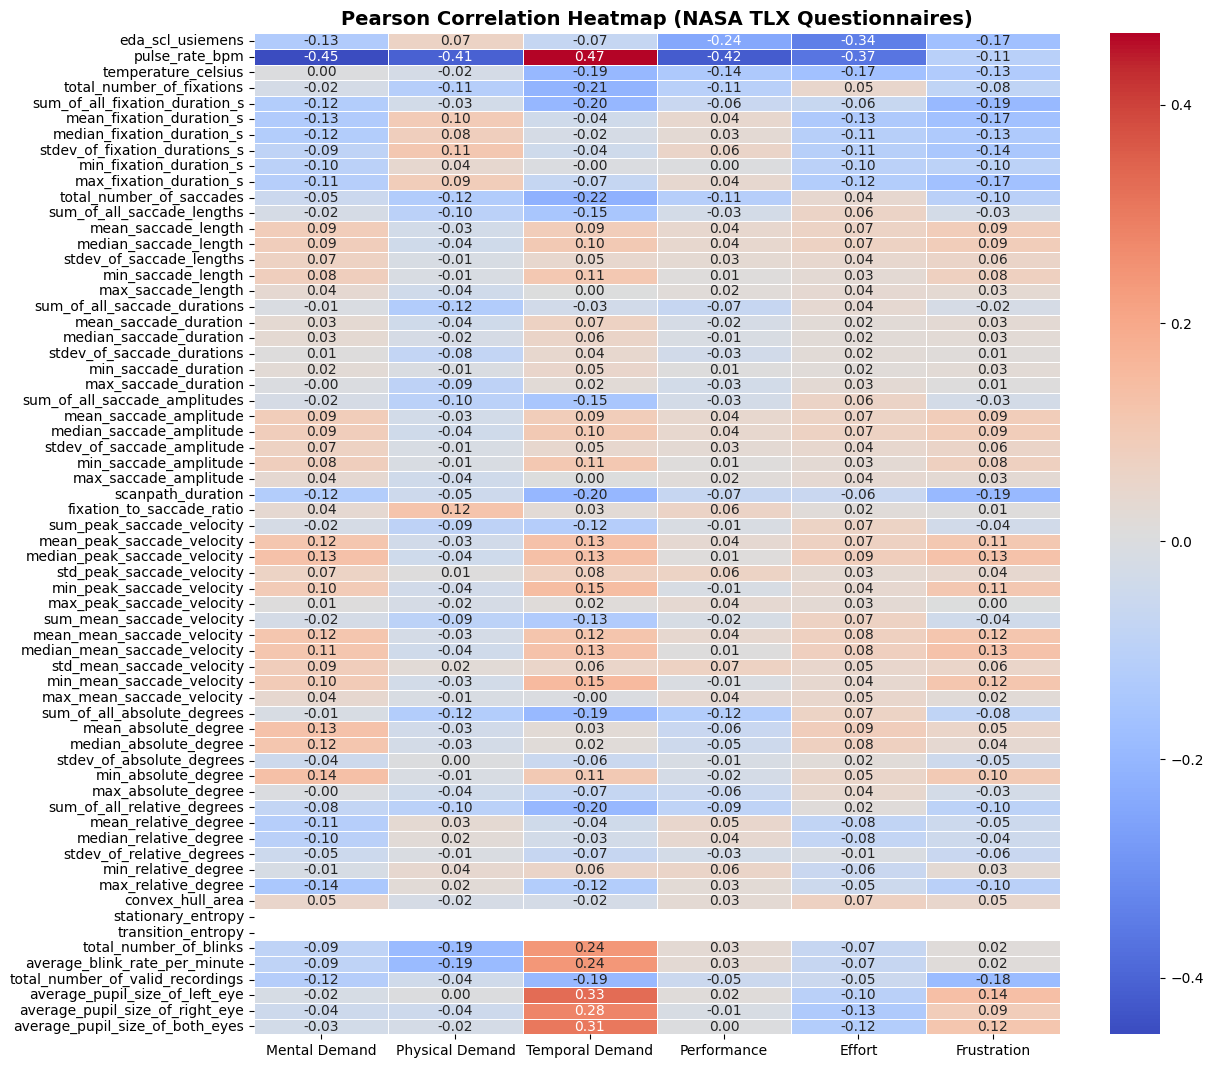

In [ ]:
NASA_TLX_metrics = ['Mental Demand', 'Physical Demand', 'Temporal Demand', 'Performance', 'Effort', 'Frustration']
correlation_matrix_NASA_TLX = df_all_physiological_data.corr()[NASA_TLX_metrics].drop(index=NASA_TLX_metrics)

# Plot the heatmap
plt.figure(figsize=(13,13))
sns.heatmap(correlation_matrix_NASA_TLX, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)

# Title
plt.title("Pearson Correlation Heatmap (NASA TLX Questionnaires)", fontsize=14, fontweight='bold')

# Show plot
plt.show()

# KSS Questionnaire - Sleepiness/Fatigue

In [ ]:
df_pre_study_KSS = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Pre-Study KSS.csv'))
df_pre_study_KSS = df_pre_study_KSS[df_pre_study_KSS['Dry Run?'].isnull()]
df_pre_study_KSS.drop(['Dry Run?', 'Timestamp'], axis=1, inplace=True)
df_pre_study_KSS.columns = [
    'Participant ID',
    'Hours Awake',
    'Sleepiness Scale',
]
df_pre_study_KSS['Sleepiness Scale'] = df_pre_study_KSS['Sleepiness Scale'].apply(lambda x: int(x.split()[0]))
df_pre_study_KSS['Study'] = 'Pre-Study'

df_post_study_KSS = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Post-Study KSS.csv'))
df_post_study_KSS = df_post_study_KSS[df_post_study_KSS['Dry Run?'].isnull()]
df_post_study_KSS.drop(['Dry Run?', 'Timestamp'], axis=1, inplace=True)
df_post_study_KSS.columns = [
    'Participant ID',
    'Sleepiness Scale',
]
df_post_study_KSS['Sleepiness Scale'] = df_post_study_KSS['Sleepiness Scale'].apply(lambda x: int(x.split()[0]))
df_post_study_KSS['Study'] = 'Post-Study'


In [ ]:
df_pre_study_KSS.head()

,Participant ID,Hours Awake,Sleepiness Scale,Study
4,4,7.0,8,Pre-Study
5,5,3.0,7,Pre-Study
6,6,7.0,5,Pre-Study
7,7,2.5,6,Pre-Study
8,8,3.0,4,Pre-Study


In [ ]:
df_post_study_KSS.head()

,Participant ID,Sleepiness Scale,Study
3,4,2,Post-Study
4,5,7,Post-Study
5,6,7,Post-Study
6,7,4,Post-Study
7,8,6,Post-Study


<Axes: xlabel='Study', ylabel='Sleepiness Scale'>

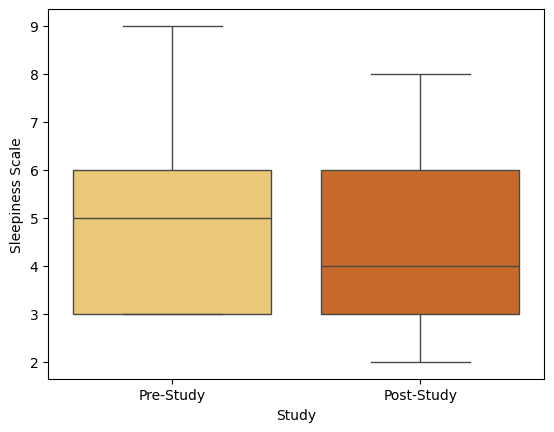

In [ ]:
sleepiness_scale = pd.concat([df_pre_study_KSS, df_post_study_KSS], axis=0)[['Sleepiness Scale', 'Study']]
sns.boxplot(data=sleepiness_scale, x='Study', y='Sleepiness Scale', palette='YlOrBr')

In [ ]:
statistic, p_value = ttest_ind(df_pre_study_KSS['Sleepiness Scale'], df_post_study_KSS['Sleepiness Scale'], equal_var=False)
_ = make_hypothesis(p_value, 'Sleepiness Scale', 'Pre and Post Questionnaires')

(p-value = 0.4233 | alpha = 0.05)
==> Fail to reject H0. There is no significant difference in Sleepiness Scale between Pre and Post Questionnaires.


On average, participants seemed to be more sleepy before studies than after, which can mean they are alert after looking at the screen for long hours. However this is not statistically significant when doing t-testing.

In [ ]:
# Merging both KSS sleepiness questionnaires into one
df_all_KSS = pd.merge(df_pre_study_KSS, df_post_study_KSS, on='Participant ID', how='inner')
df_all_KSS.rename(columns={'Sleepiness Scale_x': 'Pre-Study Sleepiness', 'Sleepiness Scale_y': 'Post-Study Sleepiness'}, inplace=True)
df_all_KSS.drop(['Study_x', 'Study_y'], inplace=True, axis=1)

In [ ]:
# Getting all dataframes in Merged Data directory, but only getting biomarker features.
df_all_physiological_data2 = []

for p in PARTICIPANTS:
    for diff in ['easy', 'hard']:
        if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
            continue # Excluded assessments (i.e ones with data loss)

        df = pd.read_csv(os.path.join(MERGED_DATA, f"Participant {p}", f"participant{p}_{diff}_assessment.csv"))[all_physiological_columns]
        df['Participant ID'] = p
        df = pd.merge(df, df_all_KSS, on='Participant ID', how='inner')
        df_all_physiological_data2.append(df)

df_all_physiological_data2 = pd.concat(df_all_physiological_data2, axis=0, ignore_index=True)
df_all_physiological_data2.drop(columns=['Participant ID'], inplace=True)

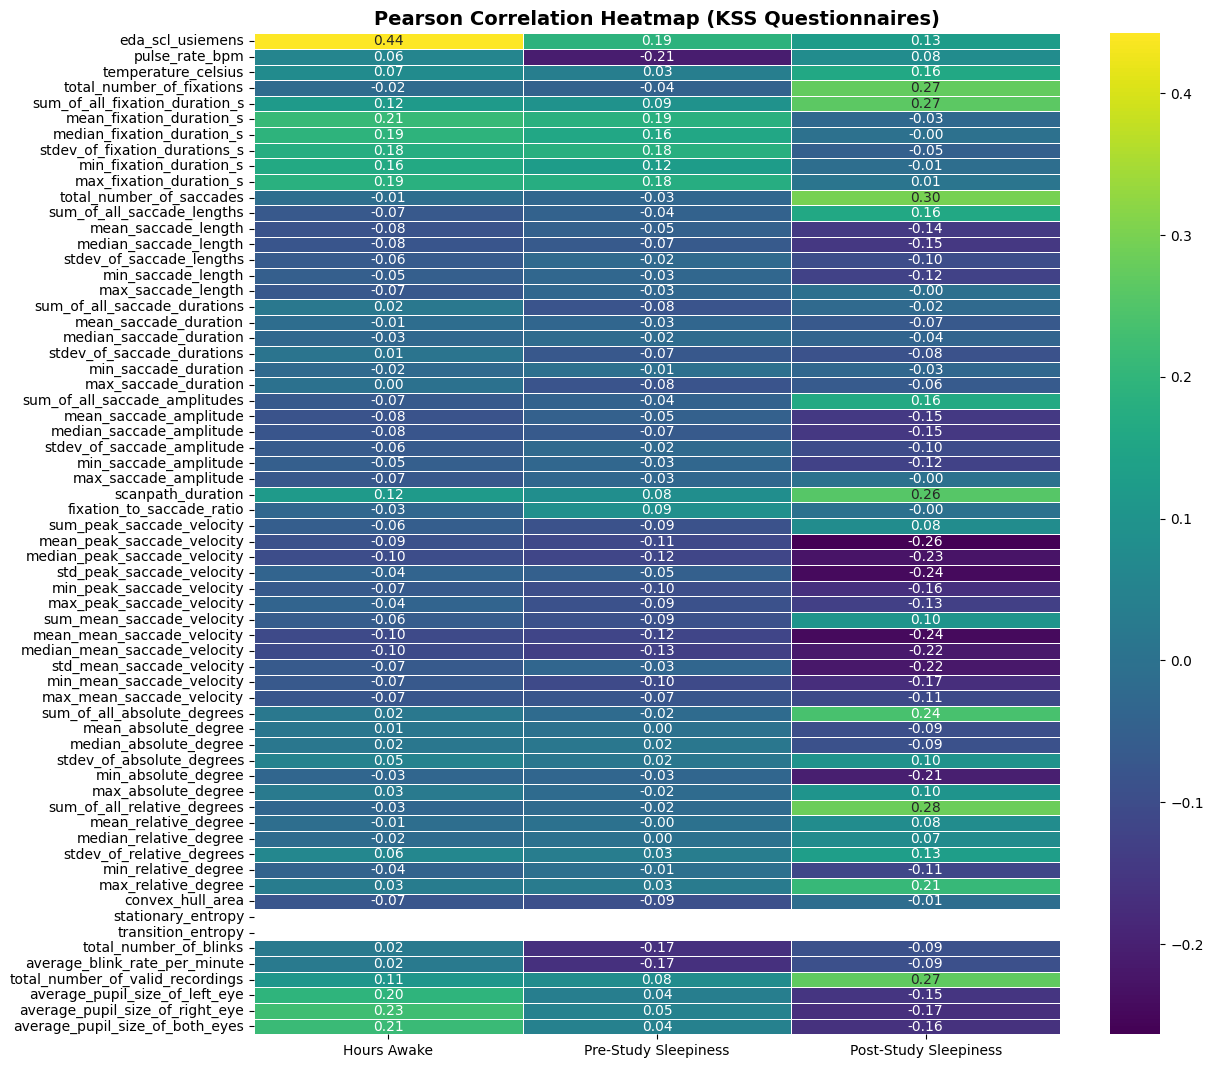

In [ ]:
KSS_metrics = ['Hours Awake', 'Pre-Study Sleepiness', 'Post-Study Sleepiness']
correlation_matrix_KSS = df_all_physiological_data2.corr()[KSS_metrics].drop(index=KSS_metrics)

# Plot the heatmap
plt.figure(figsize=(13,13))
sns.heatmap(correlation_matrix_KSS, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5, cbar=True)

# Title
plt.title("Pearson Correlation Heatmap (KSS Questionnaires)", fontsize=14, fontweight='bold')

# Show plot
plt.show()